In [1]:
import json
import networkx as nx
import numpy as np
import math
from numpy.linalg import norm

In [2]:
def readJson(path,nodeType):
    G = []
    nodes = []
    f = open(path)
    graph = json.load(f, parse_int=str)
    count = 1
    for node in graph['storeNodes']:
        nodeId = nodeType + str(count)
        nodePos = np.array([int(node['x']),int(node['y'])])
        G.append([nodeId,nodePos])
        nodes.append([nodeId,node['storeName']])
        count += 1
    return (G,nodes)

In [3]:
sGraph, sNodes = readJson("./Jsons/S1.json","S")
print('sGraph')
print(sNodes)
cGraph, cNodes = readJson("./Jsons/C1.json","C")
print('cGraph')
print(cNodes)

sGraph
[['S1', '1'], ['S2', '2'], ['S3', '3'], ['S4', '4'], ['S5', '5'], ['S6', '6'], ['S7', '7'], ['S8', '8'], ['S9', '9'], ['S10', '10'], ['S11', '11'], ['S12', '12'], ['S13', '13'], ['S14', '14'], ['S15', '15'], ['S16', '16']]
cGraph
[['C1', 'C1'], ['C2', 'C2'], ['C3', 'C3'], ['C4', 'C4']]


In [4]:
def alignNodes(G):
    i = 0
    for nodeId_i, pos_i in G:
        i += 1
        for nodeId_j, pos_j in G[i:]:
            for axis in range(2):
                if(1 <= abs(pos_i[axis] - pos_j[axis]) < 2):
                    pos_i[axis] = pos_j[axis] = (pos_i[axis] + pos_j[axis])/2
    
    i = 0
    for nodeId_i, pos_i in G:
        i += 1
        for nodeId_j, pos_j in G[i:]:
            for axis in range(2):
                if(1 <= abs(pos_i[axis] - pos_j[axis]) < 2):
                    pos_i[axis] = pos_j[axis] = int((pos_i[axis] + pos_j[axis])//2)
    return G

In [5]:
storeNodes = alignNodes(sGraph)
print("storeNodes")
print(storeNodes)
corridorNodes = alignNodes(cGraph)
print("corridorNodes")
print(corridorNodes)

storeNodes
[['S1', array([7, 4])], ['S2', array([12,  4])], ['S3', array([17,  4])], ['S4', array([36,  8])], ['S5', array([36, 15])], ['S6', array([33, 25])], ['S7', array([19, 25])], ['S8', array([10, 25])], ['S9', array([ 3, 22])], ['S10', array([ 3, 15])], ['S11', array([3, 8])], ['S12', array([12, 15])], ['S13', array([19, 13])], ['S14', array([27, 13])], ['S15', array([27, 17])], ['S16', array([19, 17])]]
corridorNodes
[['C1', array([19,  7])], ['C2', array([ 7, 13])], ['C3', array([19, 21])], ['C4', array([32, 13])]]


In [6]:
def getCorridors(G):
    G = sorted(G,key=lambda x: x[1][0])
    Corners = []
    i = 0
    for nodeId_i, pos_i in G:
        i += 1
        for nodeId_j, pos_j in G[i:]:
            if(not(pos_i[0] == pos_j[0] or pos_i[1] == pos_j[1])):
                if(not([pos_i[0],pos_j[1]] in Corners)):
                    Corners.append([pos_i[0],pos_j[1]])
                else: 
                    Corners.pop(Corners.index([pos_i[0],pos_j[1]]))

                if(not([pos_j[0],pos_i[1]] in Corners)):
                    Corners.append([pos_j[0],pos_i[1]])
                else:
                    Corners.pop(Corners.index([pos_j[0],pos_i[1]]))
    corridorCorners = []
    count = 1
    for node in Corners:
        cId = "C" + str(count)
        corridorCorners.append([cId,np.array(node)])
        count += 1

    Corridors = []
    for i in range(len(Corners)):
            for j in range(i+1,len(Corners)):
                if(Corners[i][0]==Corners[j][0]):
                    Corridors.append([0,np.array(Corners[i]),np.array(Corners[j])])
                if(Corners[i][1]==Corners[j][1]):
                    Corridors.append([1,np.array(Corners[i]),np.array(Corners[j])])
    return corridorCorners, Corridors

In [7]:
corridorCorners, corridors= getCorridors(corridorNodes)
print('corridorCorners')
print(corridorCorners)
print('corridors')
print(corridors)

corridorCorners
[['C1', array([7, 7])], ['C2', array([ 7, 21])], ['C3', array([32,  7])], ['C4', array([32, 21])]]
corridors
[[0, array([7, 7]), array([ 7, 21])], [1, array([7, 7]), array([32,  7])], [1, array([ 7, 21]), array([32, 21])], [0, array([32,  7]), array([32, 21])]]


In [8]:
# d = norm(np.cross(p2-p1, p1-p3))/norm(p2-p1)
def getCorridorNodes(storeNodes,Corridors,CorridorNodes):
    i = 0 
    for sId,storeNode in storeNodes:
        i+=1
        distance = []
        for [axis,p1,p2] in Corridors:
            d = norm(np.cross(p2-p1, p1-storeNode))/norm(p2-p1)
            if(d == 0):
                if(norm(p1-storeNode)>norm(p2-storeNode)):
                    distance.append([axis,p2.copy(),p1.copy(),p2.copy(),d])
                else:
                    distance.append([axis,p1.copy(),p1.copy(),p2.copy(),d])
            else:
                newNode = storeNode.copy()
                newNode[axis] = p1[axis]
                distance.append([axis,newNode.copy(),p1.copy(),p2.copy(),d])
       
        distance = sorted(distance, key= lambda d:d[-1])
        newNode = []
        flag = 0
        for newNodes in distance:
            if(validateNewNode(newNodes)):
                newNode = newNodes[1].copy()
                flag = 1
                break
        if(flag):
            for cId ,cnode in CorridorNodes:
                if(np.array_equal(newNode,cnode)):
                    flag = 0
                    break   
            if(flag):
                cId = "C" + str(len(CorridorNodes) + 1)
                CorridorNodes.append([cId,newNode])
    return CorridorNodes    

In [9]:
def validateNewNode(newNode):
    axis,p3,p1,p2,d = newNode
    if(d == 0):
        return True

    if(axis):
        x1 = int(min(p1[0],p2[0]))
        x2 = int(max(p1[0],p2[0])+1)
        x3 = int(p3[0])
        if(x3 in range(x1,x2)):
            return True
            
    else:
        y1 = int(min(p1[1],p2[1]))
        y2 = int(max(p1[1],p2[1])+1)
        y3 = int(p3[1])
        if(y3 in range(y1,y2)):
            return True
    
    return False

In [10]:
def intermediateCNode(corridors,corridorNodes):
    for axis, p1, p2 in corridors:
        newNode = p1.copy()
        if(axis):
            x1 = int(min(p1[0],p2[0]))
            x2 = int(max(p1[0],p2[0]))
            for x3 in range(x1+1,x2):
                newNode[0] = x3
                cId = "C"+ str(len(corridorNodes)+1)
                corridorNodes.append([cId,newNode.copy()])
        else:
            y1 = int(min(p1[1],p2[1]))
            y2 = int(max(p1[1],p2[1]))
            for y3 in range(y1+1,y2):
                newNode[1] = y3
                cId = "C"+ str(len(corridorNodes)+1)
                corridorNodes.append([cId,newNode.copy()])
    return corridorNodes

In [11]:
corridorNodes = corridorCorners.copy()
corridorNodes = intermediateCNode(corridors,corridorNodes)
corridorNodes = getCorridorNodes(storeNodes,corridors,corridorNodes)
# for cnode in corridorNodes:
#     print(cnode)

In [12]:
def connectSNodes(corridorNodes,storeNodes):
    edges = []
    for sId, p1 in storeNodes:
        distance = [9999]
        for cId, p2 in corridorNodes:
            if((p1 == p2).any()):
                d = int(norm(p2-p1))
                if(distance[-1]>d):
                    distance = [sId,cId,p1,p2,d]
                # print(distance)
        if(len(distance)==1):
            for cId, p2 in corridorNodes:
                d = int(norm(p2-p1))
                if(distance[-1]>d):
                    distance = [sId,cId,p1,p2,d]
        # if(len(distance)>1):    
        edges.append(distance)
    return edges

In [13]:
sEdges = connectSNodes(corridorNodes,storeNodes)
# for edge in sEdges:
#     print(edge)

In [14]:
def connectCNodes(corridorNodes):
    edges = []
    i = 0
    for cId_i, p1 in corridorNodes:
        # i += 1
        distance = []
        for cId_j, p2 in corridorNodes[i:]:
            if((p1 == p2).any()):
                d = int(norm(p2-p1))
                distance.append([cId_i,cId_j,p1,p2,d])
        distance = sorted(distance,key=lambda x: x[-1])
        try:
            edges.append(distance[1])
            edges.append(distance[2])
        except:
            # edges.append(distance[0])
            pass
    return edges

In [15]:
cEdges = connectCNodes(corridorNodes)
# for edge in cEdges:
#     print(edge)

In [16]:
print('allNodes')
allNodes = storeNodes.copy()
allNodes += corridorNodes
# for node in allNodes:
#     print(node)

print('allEdges')
allEdges = sEdges.copy()
allEdges += cEdges
# for edge in allEdges:
#     print(edge)

allNodes
allEdges


In [17]:
def createGraph(nodes,edges):
    G = nx.Graph()
    for [id, pos] in nodes:
        G.add_node(id,
                   storeName = id,
                   position = (pos[0],-pos[1]))
    
    for [id1, id2, p1, p2, d]  in edges:
        G.add_edge(id1,id2,weight = d)
    return G
def showGraph(G):
    pos = {}
    for node in G.nodes(data = True):
        # print(node)
        pos[node[0]] = [int(p) for p in node[1]['position'][0:2]]
    nx.draw_networkx(G, pos = pos)

In [18]:
# G = createGraph(storeNodes,sEdges)
# showGraph(G)

In [19]:
G = createGraph(corridorNodes,cEdges)
showGraph(G)


KeyError: 'S17'

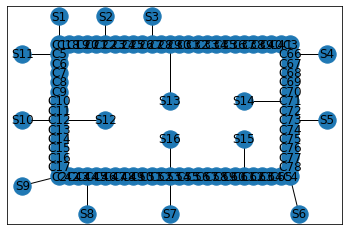

In [ ]:
G = createGraph(allNodes,allEdges)
showGraph(G)
nodes = G.nodes(data=True)
nodes['S16']

In [ ]:
def computeShortestPath(G, nodes):
    path = nx.bidirectional_dijkstra(G, nodes[0], nodes[1],weight="weight")
    return path
print(computeShortestPath(G,('S1','S8')))

(24, ['S1', 'C1', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C2', 'C42', 'C43', 'C44', 'S8'])
